In [1]:
import torch
import numpy as np
from model import make_model
from tools import Batch,CrossEntropyLossWithLabelSmoothing,get_std_opt,LossComputeAndStep,run_epoch,greedy_decode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#为了支持多模态，允许有多个输入，但目前没有多模态的需求，默认列表中只有一条序列或者有一些等长的序列
#生成器的输入序列与输出序列类型完全一样，不支持多模态！
#为了简便，默认0为填充，1为起始标记，剩余的为正常词汇，<UNK>、<END>算作正常词汇，可以在处理数据时自由定义
#生成任务与翻译任务需要在输入序列中手动添加起始标记，使得模型能够输出更长的序列
vocab_size = 12
input_vocab_sizes = [vocab_size]
output_vocab_size = vocab_size
setting = {
    #平衡资源消耗与效果
    "enable_affine" : True,                   #加快训练速度(epoch少)，几乎不影响速度，可能影响稳定性
    "enable_layer_norm" : True,               #增强模型稳定性，略微减慢速度
    "enable_talking_head" : False,             #增强模型表达能力，严重减慢速度，消耗显存
    "enable_gated_linear_unit_in_projector" : False,  #增强模型表达能力，输出词表很小时可用，规律十分明显的时候不要用
    "self_attention_block_size" : 0,          #自注意力运算时的分块大小，可以显著降低显存消耗，提供额外的位置信息，但速度较慢
    "head_number" : 8,    #启用talking_head时数量越多效果越好，但平方消耗，否则避免过大导致key_dim过小
    "glu_projector_multivalue" : 64,          #enable_gated...启用后生效，平方复杂度
    "glu_projector_deep" : 1,                 #enable_gated...启用后生效，实验用，不建议设置更大的数值
    #模型类型选择
    "model_type" : "translator",              #经典编码器-解码器架构，适合机器翻译
    # "model_type" : "classifier",              #分类器，没有解码器，编码完总结到固定长度进行分类
    # "model_type" : "generator",               #生成器，不停的预测下一个词，可以做大模型
    # "model_type" : "vit",                     #简单的图像分类 
    "share_embeddings" : False,             #是否进行词表共享，只对"translator"有效
    "summarizer_length" : 4,                #分类器的总结长度，总结时没法分块，注意资源消耗
    "patch_size" : 16,                      #图像分块的大小，只对vit有效
    "cross_attention_block_size" : 0, #在显存不足的时候对query分段计算cross_attention，会减慢速度，逻辑上与不分块一样，只有"translator"可用
    #参数规模设置
    "embedding_dim" : 64,                   #词嵌入维度
    "key_dim" : 64,                         #解决低秩问题
    "vocab_in_size_list" : input_vocab_sizes,  #输入词表大小，支持多个输入列表，可以多模态
    "vocab_out_size" : output_vocab_size,      #输出词表大小，共享词表时不支持多模态
    "feed_forward_dim" : 256,               #注意力运算结束后用于混合不同head信息的前馈网络隐藏层维度
    "model_layers_number" : 2,              #模型的层数，注意资源消耗
    #位置信息添加方式选择
    # "position_information_type" : "mask_position_information",      #掩码位置信息，如果能训练好的话可以无限外推，但可能训练有困难
    # "position_information_type" : "no_position_information",        #没有位置信息（分类器可能会用）
    # "position_information_type" : "sinusoidal_position_encoding",   #余弦位置编码（经典，高效）
    "position_information_type" : "rotary_position_encoding",       #旋转位置编码（更好的表达相对位置）
    # "position_information_type" : "rotary_position_encoding_with_random_start", #只使用相对信息，建议用掩码
    #增加泛化能力
    "dropout_rate" : 0.1 #训练时，注意力，前馈，talking都会随机丢弃计算结果，增加泛化能力
}
model = make_model(setting).to(device)
model.load_state_dict(torch.load('rot_inv_12.weight'))
optimizer = get_std_opt(model,fast=False)
criterion = CrossEntropyLossWithLabelSmoothing(output_vocab_size,smoothing=0.0)
weight_updater = LossComputeAndStep(criterion,optimizer)

In [3]:
#数据生成器
def data_generator(batch_per_epoch,batch_size,sequence_length):
    for i in range(batch_per_epoch):
        #0 代表填充、1 代表起始、2~vocab_length-1 代表正常词汇，有vocab_length-2个，np.random.randint取不到第二个参数
        np_data = np.random.randint(2,vocab_size,size=(batch_size,sequence_length+1))
        np_data[...,0] = 1
        input_sequence = torch.from_numpy(np_data[...,1:]).to(device)
        input_sequences = [input_sequence]
        np_data[...,1:] = np_data[...,1:][...,::-1]
        target_sequences = torch.from_numpy(np_data).to(device)
        yield Batch(input_sequences,target_sequences)

In [4]:
#训练时使用的数据格式
sequence_length = 32
batch_size = 64
batch_per_epoch = 100
num_of_epochs = 100
#训练终止标志
stop_loss = 0.01
#进行训练
for epoch in range(num_of_epochs):
    print("Epoch:",epoch)
    model.train()
    run_epoch(model,data_generator(batch_per_epoch,batch_size,sequence_length),weight_updater)
    model.eval()
    with torch.no_grad():
        if run_epoch(model,data_generator(batch_per_epoch//5,batch_size,sequence_length),weight_updater) <= stop_loss and epoch > 5:
            break
#进行检查
model.eval()
with torch.no_grad():
    #0 代表填充、1 代表起始、2~vocab_length-1 代表正常词汇，有vocab_length-2个，np.random.randint取不到第二个参数
    check_data = np.random.randint(2,vocab_size,size=(1,sequence_length+1))
    check_data[...,0] = 1
    input_sequence = torch.from_numpy(check_data[...,1:]).to(device)
    input_sequences = [input_sequence]
    result = greedy_decode(model,input_sequences,out_length=sequence_length)
    check_data[...,1:] = check_data[...,1:][...,::-1]
    answer = torch.from_numpy(check_data[...,1:]).to(device)
    print(result)
    print(answer)

Epoch: 0
Step: 0 Loss: 5.661722 Tokens per Sec: 8745.187913
total_step: 50 lr: 4.9999999999999996e-05
Step: 50 Loss: 4.230529 Tokens per Sec: 59626.137743
total_step: 100 lr: 9.999999999999999e-05
Step: 0 Loss: 2.228503 Tokens per Sec: 277542.313150
Epoch: 1
Step: 0 Loss: 2.288491 Tokens per Sec: 62730.473016
total_step: 150 lr: 0.00015
Step: 50 Loss: 2.226452 Tokens per Sec: 64043.769232
total_step: 200 lr: 0.00019999999999999998
Step: 0 Loss: 1.107818 Tokens per Sec: 277829.568277
Epoch: 2
Step: 0 Loss: 1.511537 Tokens per Sec: 34581.753224
total_step: 250 lr: 0.00025
Step: 50 Loss: 0.847188 Tokens per Sec: 47803.624288
total_step: 300 lr: 0.0003
Step: 0 Loss: 0.016316 Tokens per Sec: 91799.286033
Epoch: 3
Step: 0 Loss: 0.312275 Tokens per Sec: 32147.477553
total_step: 350 lr: 0.00035
Step: 50 Loss: 0.225873 Tokens per Sec: 36110.369060
total_step: 400 lr: 0.00039999999999999996
Step: 0 Loss: 0.003540 Tokens per Sec: 152571.616703
Epoch: 4
Step: 0 Loss: 0.144038 Tokens per Sec: 48178

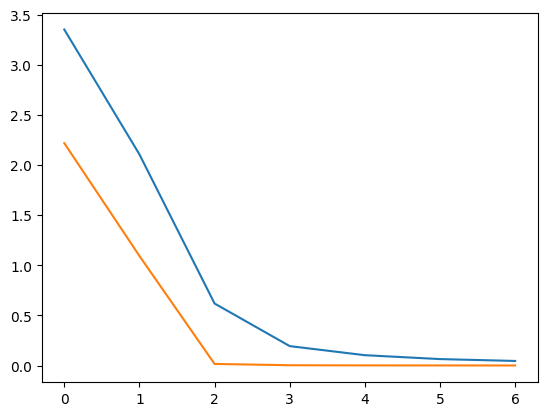

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.close()
plt.plot(weight_updater.recorder.train_loss_line_per_epoch)
plt.plot(weight_updater.recorder.test_loss_line_per_epoch)

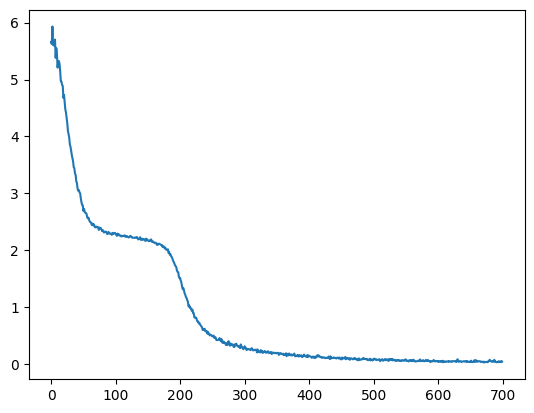

In [6]:
plt.close()
plt.plot(weight_updater.recorder.train_loss_line)

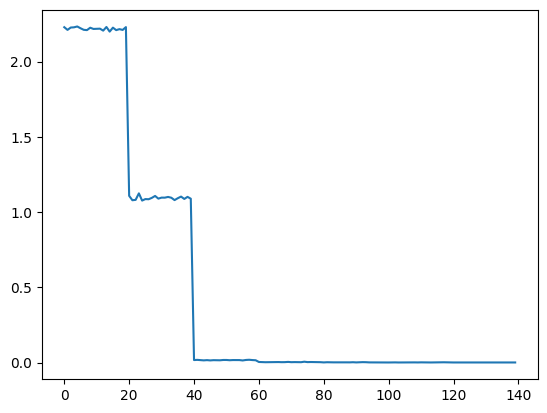

In [7]:
plt.close()
plt.plot(weight_updater.recorder.test_loss_line)

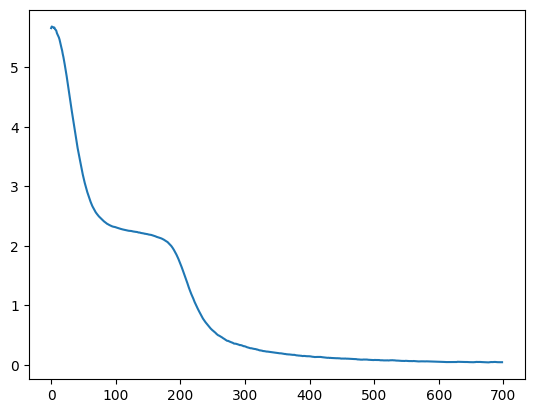

In [8]:
plt.close()
plt.plot(weight_updater.recorder.mean_loss_line)

In [9]:
torch.save(model.state_dict(),'rot_inv_32.weight')